# 3.3

Предложить метод выбора наиболее важных признаков для логистической регрессии на основе изученных методов прикладной статистики. Осуществить выбор.

Выборка: [Wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html)

------

Можно было бы воспользоваться ANOVA и провести F-test для поиска наиболее информативных признаков. Но на основе изученных методов мы можем проверять корреляцию и на основе ее делать выводы о важности признаков. Мы хотим оценивать линейную взаимосвязь таргета с несколькими признаками. Поэтому будем использовать множественную корреляцию.

In [33]:
import numpy.random
import numpy as np
import pandas as pd
import scipy.stats as st
from tqdm import tqdm
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

mpl.style.use('seaborn')
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = (11.0, 7.0)

In [12]:
from sklearn.datasets import load_wine

raw = load_wine()
data = raw.data
targets = raw.target
feature_names = raw.feature_names
df = pd.DataFrame(np.hstack((data, targets.reshape(-1, 1))), columns=feature_names + ['target'])

Посмотрим предварительно на данные

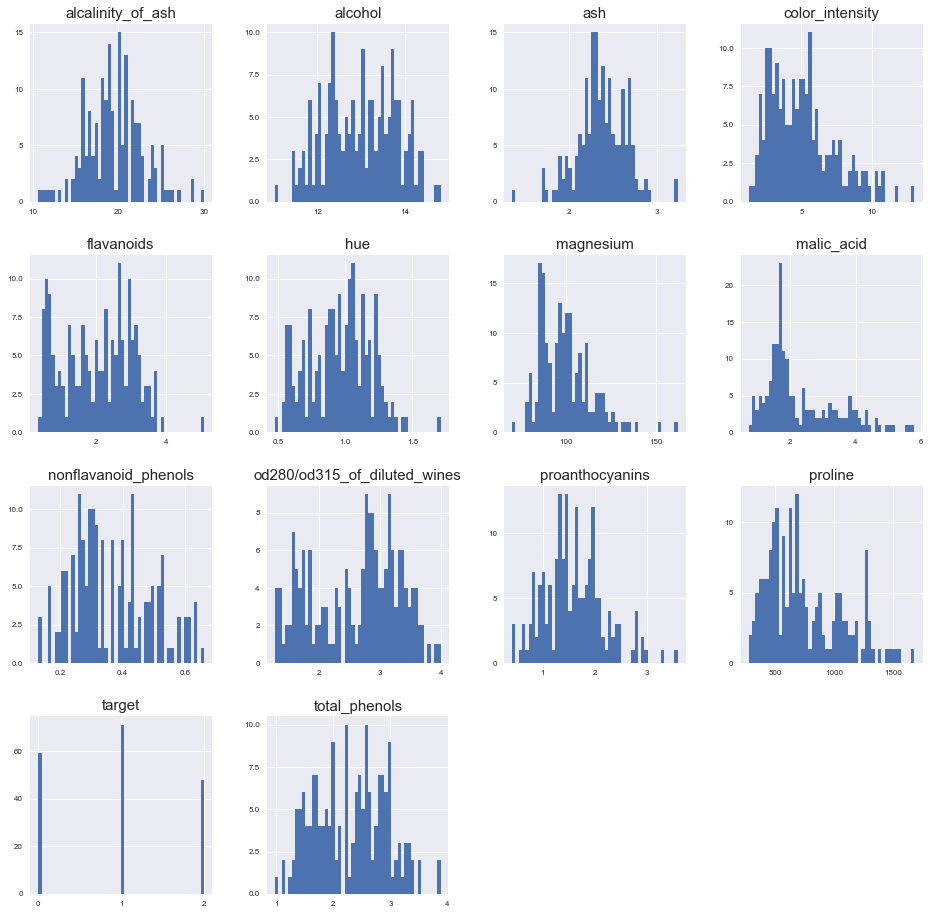

In [17]:
df.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);

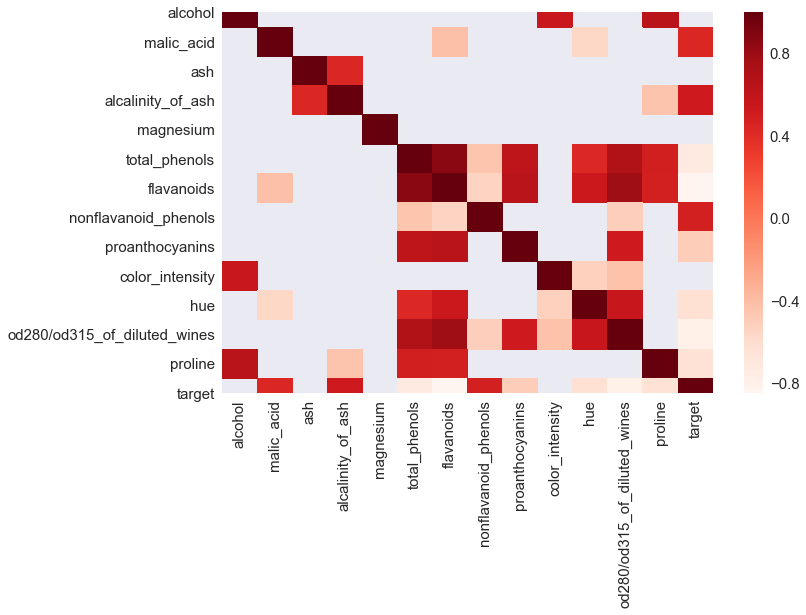

In [31]:
corr = df.corr()
sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="Reds")

Видим, что некоторые признаки сильно скоррелированы между собой, значит, действительно, стоит попробовать оценивать важность по корреляции. Множественная корреляция находится как
$$r_{X, M}^{2}=c^{T} R c$$
где $\Omega$ — обратимая матрица выборочных корреляций признаков, $R=\Omega^{-1}$, $c$ — вектор корреляций таргета со всеми признаками.

In [46]:
def multiple_corr(features, target):
    c = np.array([st.pearsonr(x, target)[0] for x in features])
    if len(c) == 1: #обычная корреляция между двумя признаками
        return c[0]
    
    R = np.linalg.inv(np.corrcoef(features))
    return np.sqrt(c.T @ R @ c)

Будем перебирать все комбинации признаков и смотреть множественную корреляцию на этих комбинациях.

In [70]:
from itertools import chain, combinations

def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1)))

for i in all_subsets([0,1,2]):
    print(i)

()
(0,)
(1,)
(2,)
(0, 1)
(0, 2)
(1, 2)
(0, 1, 2)


Также стоит учесть, что наш таргет – категориальная переменная, которой в соответствие поставили число. Нужно убрать влияние того, что, например $2>0$, что не имеет смысла для нашего таргета. Поэтому будем считать корреляцию как среднее корреляций по возможным переименованиям таргетов. Т.е. (0,1,2), (1,2,0), (2,0,1), остальные переименования (перестановки) дадут просто те же значения корреляций с отрицательным знаком, поэтому рассмтриваем только три этих.

In [71]:
targets_1 = np.copy(targets)
targets_2 = targets_3 =  np.zeros_like(targets)
targets_2[targets == 0], targets_2[targets == 1], targets_2[targets == 2] = 1, 2, 0
targets_3[targets == 0], targets_3[targets == 1], targets_3[targets == 2] = 2, 0, 1

In [144]:
num_features = [i+1 for i in range(len(feature_names))]
num_features

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Получим для каждого количества признаков в комбинации признаки, дающие максимальную корреляцию

In [99]:
correlations = []
for i in tqdm(num_features):
    corr_temp = []
    names_temp = []
    for names in all_subsets(feature_names):
        if len(names) == i:
            features = df[list(names)].values.T
            corr_1 = multiple_corr(features, targets_1)
            corr_2 = multiple_corr(features, targets_2)
            corr_3 = multiple_corr(features, targets_3)
            corr_temp.append(np.mean([corr_1, corr_2, corr_3]))
            names_temp.append(names)  
    correlations.append((corr_temp[np.argmax(corr_temp)], 
                         names_temp[np.argmax(corr_temp)], 
                         len(names_temp[np.argmax(corr_temp)])))

100%|██████████| 13/13 [00:26<00:00,  2.04s/it]


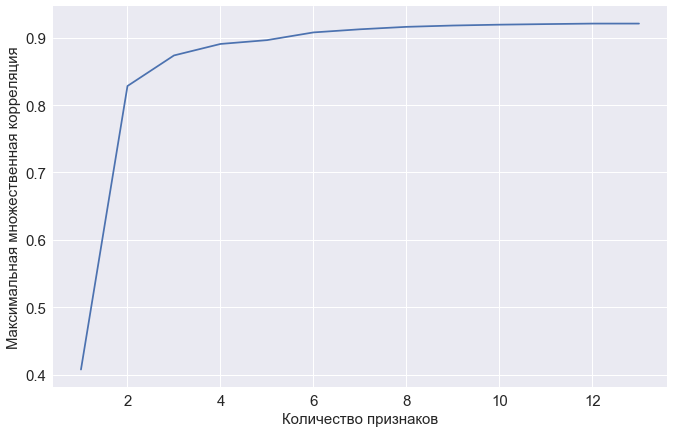

In [105]:
plt.plot(num_features, [i[0] for i in correlations])
plt.xlabel('Количество признаков')
plt.ylabel('Максимальная множественная корреляция');

Видим, что после 4-5 признаков добавление новых не сильно улучшает значение корреляции(график выходит на плато). Из этого делаем вывод, что стоит взять 4-5 признаков, как самые важные. Возьмем, например, 4

In [108]:
print(correlations[3][1])

('alcohol', 'flavanoids', 'color_intensity', 'proline')


Посмотрим, что даст F-test

/Users/Pablo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


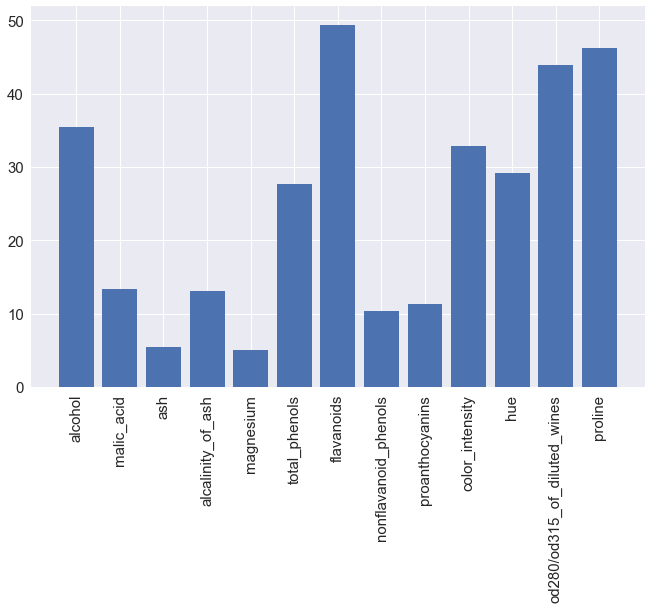

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k='all')
selector.fit(df.drop(['target'], axis=1), df[['target']])

#самый большой результат соответствует самому малому значению p-значения(вероятность ошибки)
scores = -np.log10(selector.pvalues_)

plt.bar(range(len(feature_names)), scores)
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

Посмотрим на pairplot с признаками, полученными с помощью анализа корреляций

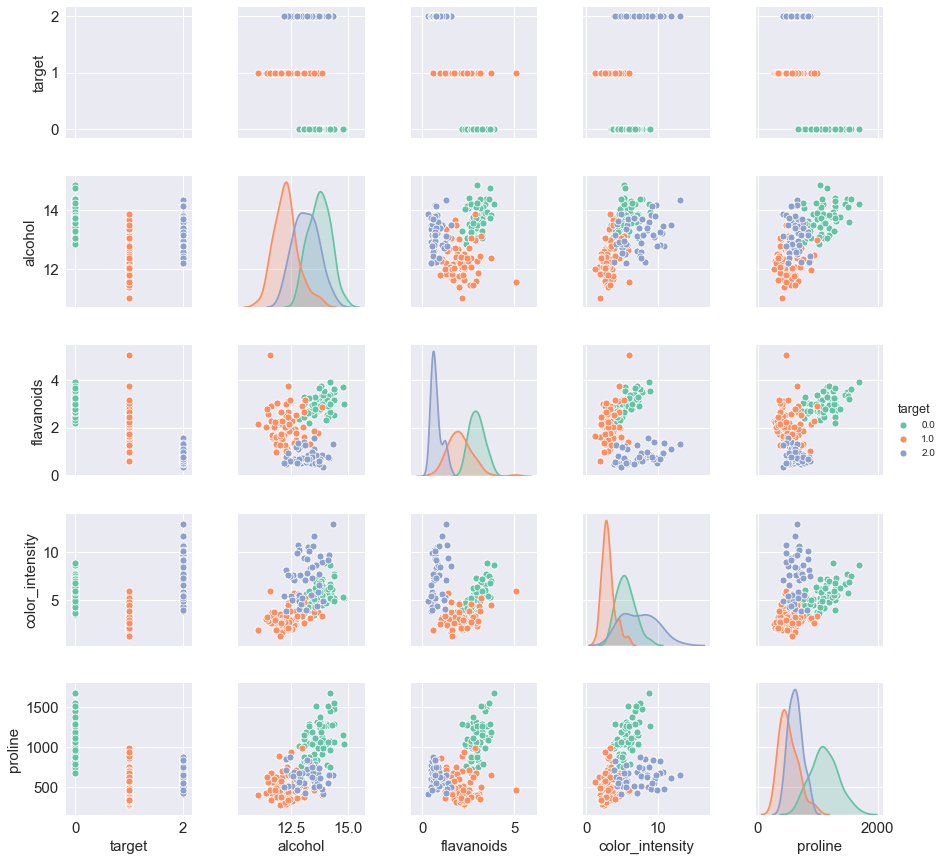

In [116]:
new_wine = df[['target','alcohol', 'flavanoids', 'color_intensity', 'proline']]
sns_plot = sns.pairplot(new_wine, hue='target', palette="Set2", diag_kind="kde")

### Вывод

Как видим, результат F-test почти такой же, как и в случае с корреляцией, что показывает верность нашего метода. Наилучшие признаки по F-test: alcohol, flavanoids, color_intensity, proline и od280/od315_of_diluted_wines. 
Для метода с корреляцией: ('alcohol', 'flavanoids', 'color_intensity', 'proline')

Отличие с корреляциями: od280/od315_of_diluted_wines. Возможная причина отличия – то, что мы для корреляций брали средние корреляций по перестановкам имен таргета и, что на плато выходит на 4-5 признаках, а не точно на четырех. Также могло сыграть и то, что брали среднее, возможно, лучше стоило брать максимальное.

Посмотрим ради интереса на качество классификации с данными признаками и сравним с классификацией при учете всех признаков.

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, 
                                                    random_state=42, stratify=targets)

In [141]:
best_features = correlations[3][1]
idxs = np.where(np.isin(feature_names, best_features))[0]

model = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)
print('test accuracy on all features {}'.format(np.round(model.score(X_train, y_train), 4)))
print('test accuracy on all features {}'.format(np.round(model.score(X_test, y_test), 4)))

model.fit(X_train[:, idxs], y_train)
print('test accuracy on best features {}'.format(np.round(model.score(X_train[:, idxs], y_train), 4)))
print('test accuracy on best features {}'.format(np.round(model.score(X_test[:, idxs], y_test), 4)))

test accuracy on all features 0.9839
test accuracy on all features 0.9815
test accuracy on best features 0.9758
test accuracy on best features 0.9815


Качество на train почти не изменилось, а на test вообще такое же